In [1]:
from google.colab import drive
# drive.mount("/content/drive")

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

from scipy.stats import zscore
from scipy.stats import chi2_contingency

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Functions

In [4]:
def data_quality_check(data_input, target_variable):
    quality_metrics = pd.DataFrame(index=data_input.columns)

    # data types
    quality_metrics["Types"] = data_input.dtypes

    # number of unique values
    quality_metrics["Unique"] = data_input.nunique()
    # missing values checking
    quality_metrics["Missing"] = data_input.isnull().sum()

    # outiers checking
    outliers = {}
    numeric_cols = data_input.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        z_scores = zscore(data_input[col])
        outliers[col] = ((z_scores > 3) | (z_scores < -3)).sum()

    quality_metrics["Outliers"] = quality_metrics.index.map(lambda x: outliers.get(x, 0))

    #summary stats
    summary_stats = data_input.describe().T[["mean", "std", "50%", "min", "max"]]
    quality_metrics = pd.concat([quality_metrics, summary_stats], axis=1)

    return quality_metrics

In [5]:
def num_distribution_plot(data_input, variables):
    # numerical_features = data_input.select_dtypes(include=["int64", "float64"])
    numerical_features = variables["numerical"]

    num_cols = len(numerical_features)
    num_rows = (num_cols // 2) + (num_cols % 2)

    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))

    for i, feature in enumerate(numerical_features):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        if feature in data_input.columns:
            sns.histplot(data=data_input, x=feature, kde=True, ax=ax)
            ax.set_title(f"Distribution Plot of {feature}")
            ax.set_xlabel(feature)
            ax.set_ylabel("Frequency")
        else:
            ax.axis("off")

    if num_cols % 2 != 0:
        axs[-1, -1].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
def cat_distribution_plot(data_input, variables):
    categorical_features = variables["categorical"]
    target_variable = variables["target"]

    cat_cols = len(categorical_features) + 1
    cat_rows = (cat_cols // 2) + (cat_cols % 2)

    fig, axs = plt.subplots(cat_rows, 2, figsize=(15, 4*cat_rows))

    all_features = categorical_features + [target_variable]

    for i, feature in enumerate(all_features):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        if feature in data_input.columns:
            sns.countplot(x=feature, data=data_input, ax=ax)
            ax.set_title(f"Distribution Plot of {feature}")
            ax.set_xlabel(feature)
            ax.set_ylabel("Count")
        else:
            ax.axis("off")

    if cat_cols % 2 != 0:
        axs[-1, -1].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
# def cat_distribution_plot(data_input):
#     categorical_features = data_input.select_dtypes(include=["object"])

#     cat_cols = len(categorical_features.columns)
#     cat_rows = (cat_cols // 2) + (cat_cols % 2)

#     fig, axs = plt.subplots(cat_rows, 2, figsize=(15, 4*cat_rows))

#     for i, feature in enumerate(categorical_features.columns):
#         row = i//2
#         col = i%2
#         ax = axs[row, col]

#         sns.countplot(x=feature, data=data_input, ax=ax)
#         ax.set_title(f"Distribution Plot of {feature}")
#         ax.set_xlabel(feature)
#         ax.set_ylabel("Count")

#     if cat_cols % 2 != 0:
#         axs[-1, -1].axis("off")

#     plt.tight_layout()
#     plt.show()

In [8]:
def extract_feats_importance(model, feature_names=None):
    if feature_names is None:
        if hasattr(model, "feature_importances_"):
            return model.feature_importances_
        elif hasattr(model, "coef_"):
            return np.abs(model.coef_)
        else:
            print("Model does not support feature importance or feature names are not provided")
            return None
    else:
        if hasattr(model, "feature_importances_"):
            return(dict(zip(feature_names, model.feature_importances_)))
        elif hasattr(model, "coef_"):
            return dict(zip(feature_names, np.abs(model.coef_)))
        else:
            print("Model does not support feature importance.")
            return None

In [9]:
def model_evaluation(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, mcc, roc_auc, cm

# Data Preparation

In [10]:
df = pd.read_csv("/content/drive/MyDrive/ML_GroupProject/Base.csv")

# Data Understanding

In [11]:
df.shape

(1000000, 32)

In [12]:
df.fraud_bool.value_counts(normalize=True)

fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64

Data is highly imbalanced

In [13]:
quality_metrics = data_quality_check(df, "fraud_bool")
quality_metrics

,Types,Unique,Missing,Outliers,mean,std,50%,min,max
fraud_bool,int64,2,0,11029,0.011029,0.104438,0.000000,0.000000e+00,1.000000
income,float64,9,0,0,0.562696,0.290343,0.600000,1.000000e-01,0.900000
name_email_similarity,float64,998861,0,0,0.493694,0.289125,0.492153,1.434550e-06,0.999999
prev_address_months_count,int64,374,0,25310,16.718568,44.046230,-1.000000,-1.000000e+00,383.000000
current_address_months_count,int64,423,0,21483,86.587867,88.406599,52.000000,-1.000000e+00,428.000000
customer_age,int64,9,0,7890,33.689080,12.025799,30.000000,1.000000e+01,90.000000
days_since_request,float64,989330,0,17775,1.025705,5.381835,0.015176,4.036860e-09,78.456904
intended_balcon_amount,float64,994971,0,18960,8.661499,20.236155,-0.830507,-1.553055e+01,112.956928
payment_type,object,5,0,0,NaN,NaN,NaN,NaN,NaN
zip_count_4w,int64,6306,0,16247,1572.692049,1005.374565,1263.000000,1.000000e+00,6700.000000


Outliers treatment?


*   Don't remove as it may be important to detect fraud. Gonna check the outlier with fraud label, if majority fraud_bool == 1 then may need to be remained.
*   Remove? As it has very cases



In [14]:
variables = {
    "categorical": [
        "payment_type",
        "employment_status",
        "email_is_free",
        "housing_status",
        "phone_home_valid",
        "phone_mobile_valid",
        "has_other_cards",
        "foreign_request",
        "source",
        "device_os",
        "keep_alive_session",
    ],
    "numerical": [
        "income",
        "name_email_similarity",
        "prev_address_months_count",
        "current_address_months_count",
        "customer_age",
        "days_since_request",
        "intended_balcon_amount",
        "zip_count_4w",
        "velocity_6h",
        "velocity_24h",
        "velocity_4w",
        "bank_branch_count_8w",
        "date_of_birth_distinct_emails_4w",
        "credit_risk_score",
        "bank_months_count",
        "proposed_credit_limit",
        "session_length_in_minutes",
        "device_distinct_emails_8w",
        "device_fraud_count",
        "month",
    ],
    "target": "fraud_bool",
}

# Distribution Plot

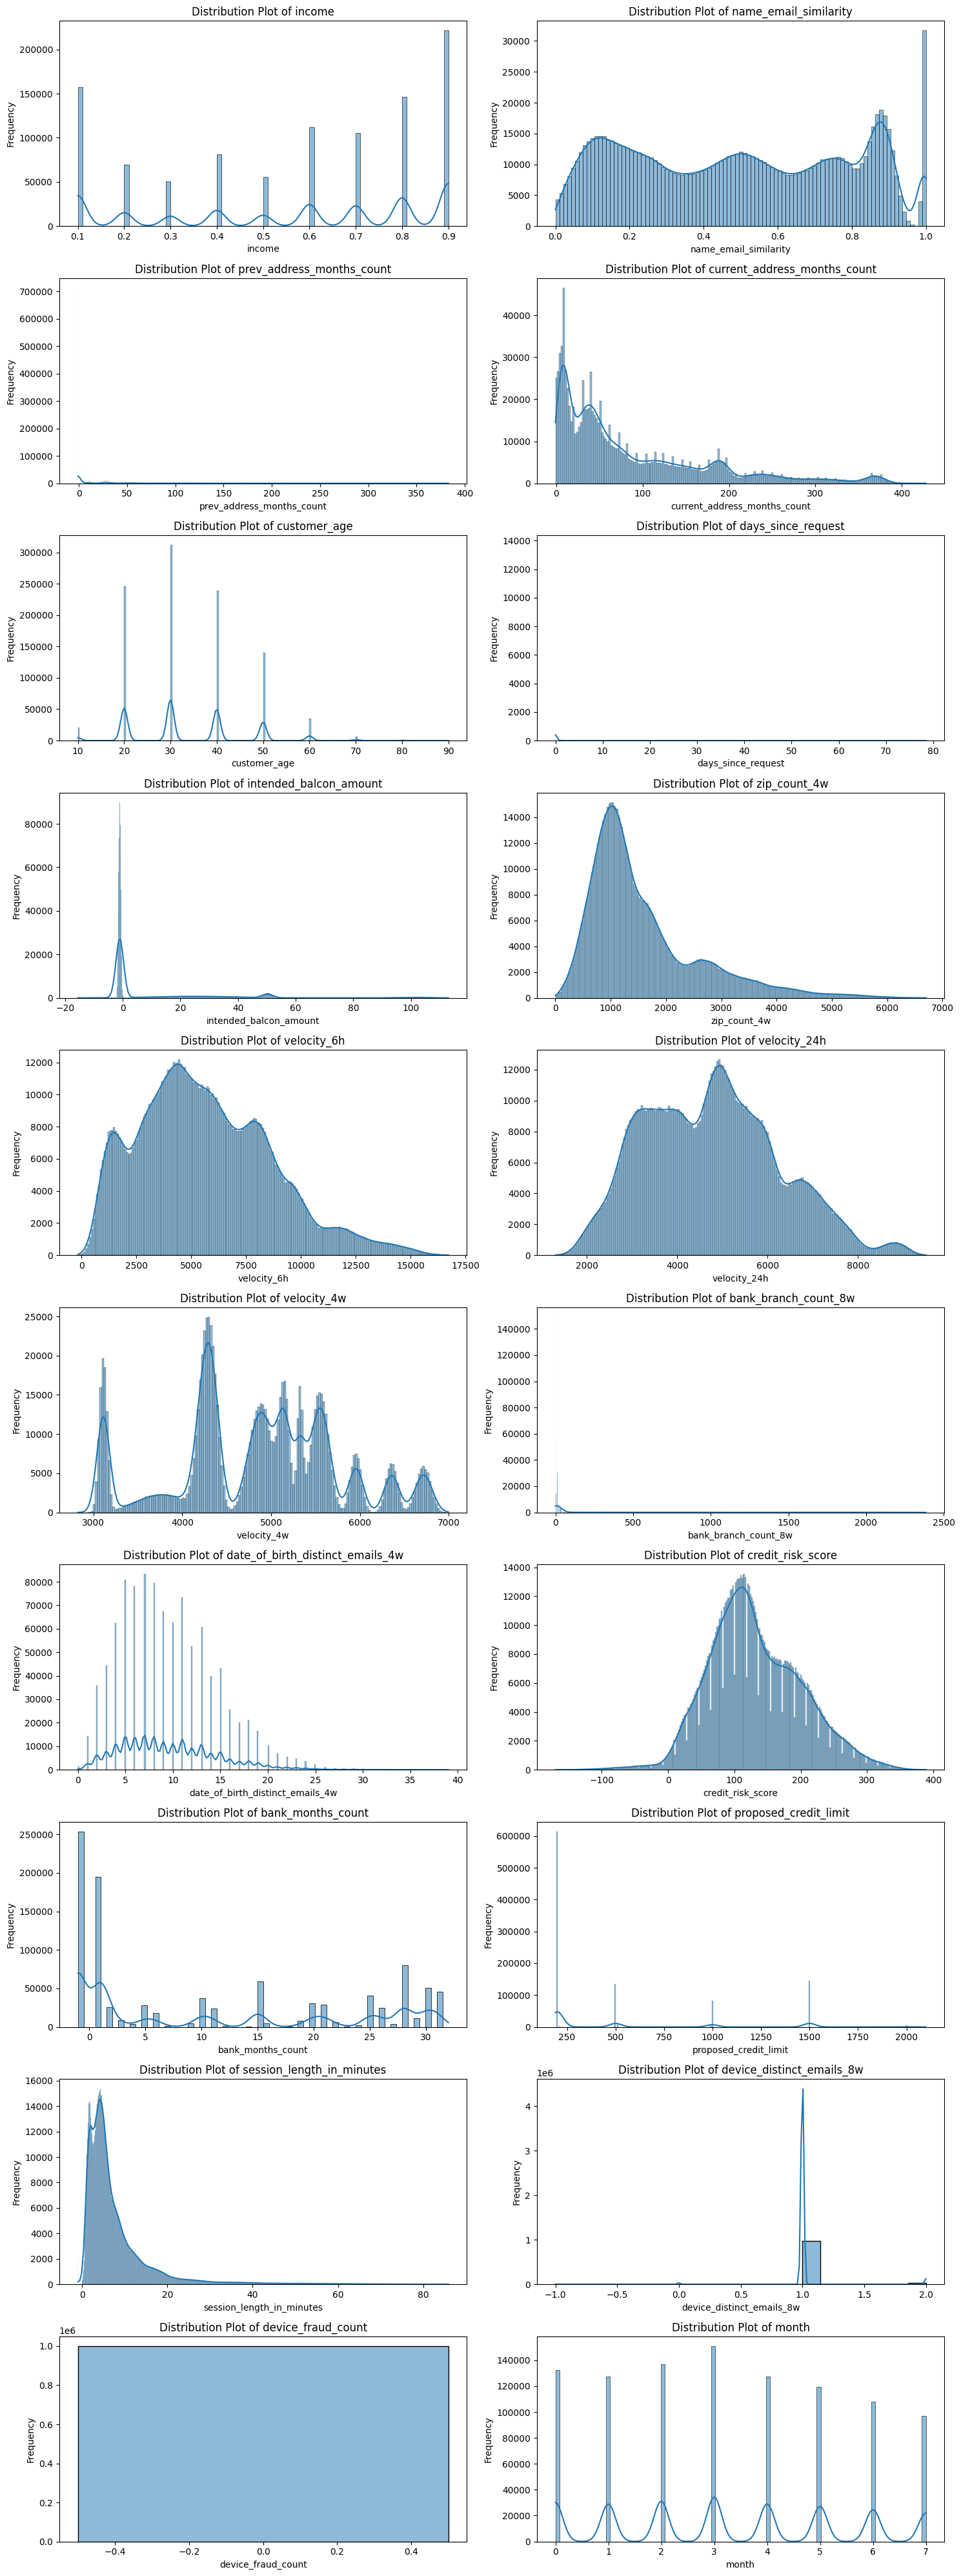

In [15]:
num_distribution_plot(df, variables)

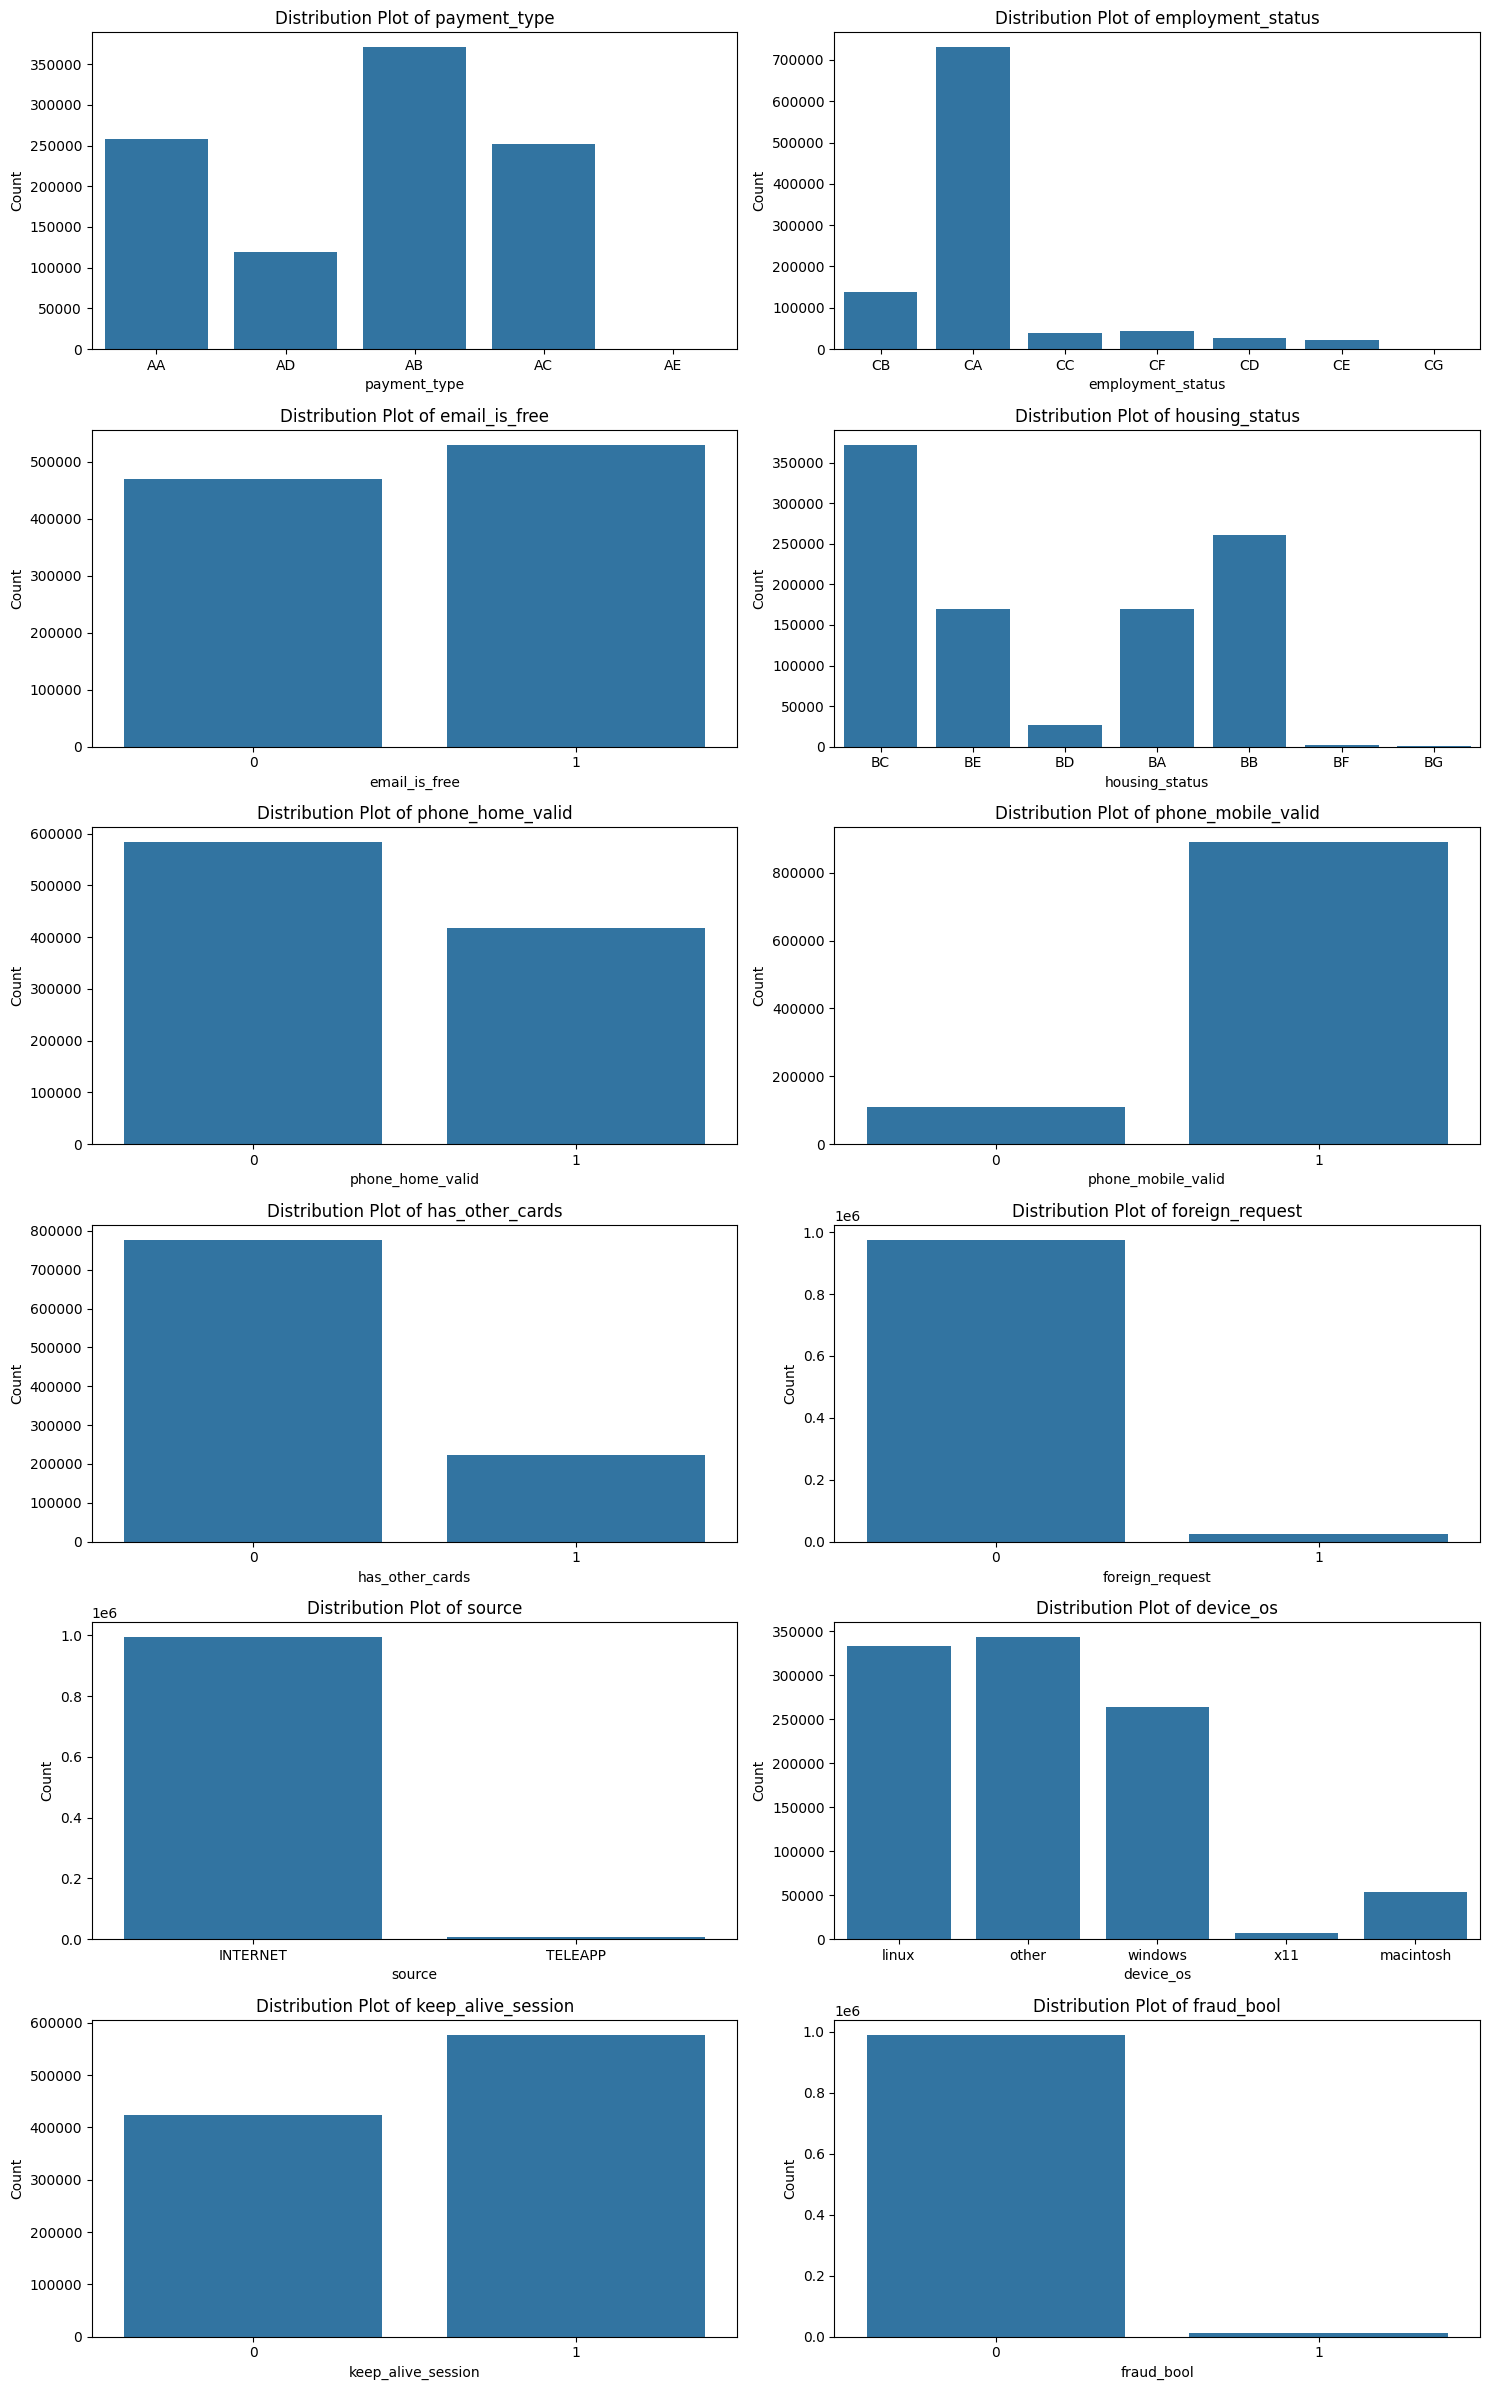

In [16]:
cat_distribution_plot(df, variables)

# Data Manipulation

Standard Scaling when:


*   features with different units or scales
*   data follows normal distribution
*   sensitive to outliers

Normalisation when:
*   there is outliers
*   preserve the original distirbution shape of the features



In [17]:
def label_encode_cat(df_input):
    label_encoder = LabelEncoder()
    encoded_values = {}
    for column in df_input.columns:
        if df_input[column].dtype == "object":
            df_input[column] = label_encoder.fit_transform(df_input[column])
            encoded_values[column] = dict(zip(label_encoder.classes_,
                                              label_encoder.transform(label_encoder.classes_)))
    return df_input, encoded_values

In [18]:
df_encoded, encoded_dict = label_encode_cat(df)
encoded_dict

{'payment_type': {'AA': 0, 'AB': 1, 'AC': 2, 'AD': 3, 'AE': 4},
 'employment_status': {'CA': 0,
  'CB': 1,
  'CC': 2,
  'CD': 3,
  'CE': 4,
  'CF': 5,
  'CG': 6},
 'housing_status': {'BA': 0,
  'BB': 1,
  'BC': 2,
  'BD': 3,
  'BE': 4,
  'BF': 5,
  'BG': 6},
 'source': {'INTERNET': 0, 'TELEAPP': 1},
 'device_os': {'linux': 0, 'macintosh': 1, 'other': 2, 'windows': 3, 'x11': 4}}

In [19]:
# output encoded df to R for ACE scores computation
# file_path = "/content/drive/MyDrive/ML_GroupProject/df_encoded.csv"
# df_encoded.to_csv(file_path, index=False)

In [20]:
# r code to get ACE score
# library(acepack)

# df <- read.csv("/Users/chooenming/Downloads/df_encoded.csv")

# dependent_variable <- df$fraud_bool
# independent_variables <- df[, !names(df) %in% "fraud_bool"]

# features <- names(independent_variables)
# ace_scores <- numeric(length(independent_variables))

# # Run ACE algorithm for each independent variable and calculate correlation
# for (i in 1:length(independent_variables)) {
#   ace_result <- ace(independent_variables[, i], dependent_variable)
#   ace_scores[i] <- ace_result$rsq
# }

# ace_scores_df <- data.frame(features, ace_scores)
# ace_scores_df <- ace_scores_df[order(-ace_scores_df$ace_scores), ]
# print(ace_scores_df)

# file_path <- "/Users/chooenming/Downloads/ace_scores.csv"
# write.csv(ace_scores_df, file = file_path, row.names=FALSE)

# from the ace scores - drop the last 3 variables (due to low / negligible ace scores)


*   `zip_count_4w`
*   `source`
*   `device_fraud_count`



In [21]:
columns_to_drop = ["zip_count_4w", "source", "device_fraud_count"]
df_after_ace = df_encoded.drop(columns=columns_to_drop)

In [22]:
variables = {
    "categorical": [
        "payment_type",
        "employment_status",
        "email_is_free",
        "housing_status",
        "phone_home_valid",
        "phone_mobile_valid",
        "has_other_cards",
        "foreign_request",
        # "source", # drop
        "device_os",
        "keep_alive_session",
    ],
    "numerical": [
        "income",
        "name_email_similarity",
        "prev_address_months_count",
        "current_address_months_count",
        "customer_age",
        "days_since_request",
        "intended_balcon_amount",
        # "zip_count_4w", # drop
        "velocity_6h",
        "velocity_24h",
        "velocity_4w",
        "bank_branch_count_8w",
        "date_of_birth_distinct_emails_4w",
        "credit_risk_score",
        "bank_months_count",
        "proposed_credit_limit",
        "session_length_in_minutes",
        "device_distinct_emails_8w",
        # "device_fraud_count", # drop
        "month",
    ],
    "target": "fraud_bool",
}

In [23]:
# def scale_col(df_input, columns, scaler_type):
#     df_scaled = df_input.copy()
#     if scaler_type == "min_max":
#         scaler = MinMaxScaler()
#     elif scaler_type == "standard":
#         scaler = StandardScaler()
#     else:
#         raise ValueError("Invalid scaler_type. Use 'min_max' or 'standard'.")

#     for col in columns:
#         if col in df_input.columns:
#             column_data = df_input[col].values.reshape(-1, 1)
#             df_scaled[col] = scaler.fit_transform(column_data)

#     return df_scaled

In [24]:
# # columns for MinMaxScaler
# col_min_max_scale = [var for var in variables["numerical"] if var != "credit_risk_score"]
# # columns for StandardScaler
# col_std_scale = [var for var in variables["numerical"] if var == "credit_risk_score"]

# df_scaled = scale_col(df_after_ace, col_min_max_scale, "min_max")
# df_scaled = scale_col(df_scaled, col_std_scale, "standard")

# Ensemble Feature Selection

In [25]:
df_after_ace.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'employment_status', 'credit_risk_score', 'email_is_free',
       'housing_status', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'device_os',
       'keep_alive_session', 'device_distinct_emails_8w', 'month'],
      dtype='object')

In [26]:
y = df_after_ace["fraud_bool"]
X = df_after_ace.drop(columns="fraud_bool")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=1234,
                                                    stratify = y)

In [28]:
y_train.value_counts()
# y_train_resampled.value_counts()

fraud_bool
0    692280
1      7720
Name: count, dtype: int64

In [29]:
smote = SMOTE(random_state=1234)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [30]:
y_train_resampled.value_counts()

fraud_bool
0    692280
1    692280
Name: count, dtype: int64

In [31]:
def scale_col(df_to_fit, df_to_transform, columns, scaler_type):
    if scaler_type == "min_max":
        scaler = MinMaxScaler()
    elif scaler_type == "standard":
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid scaler_type. Use 'min_max' or 'standard'.")

    df_fit_scaled = df_to_fit.copy()
    df_transform_scaled = df_to_transform.copy()

    for col in columns:
        if col in df_to_fit.columns and col in df_to_transform.columns:
            # Fit the scaler on the fitting DataFrame
            scaler.fit(df_to_fit[[col]])

            # Transform both fitting and transforming DataFrames
            df_fit_scaled[col] = scaler.transform(df_to_fit[[col]])
            df_transform_scaled[col] = scaler.transform(df_to_transform[[col]])

    return df_fit_scaled, df_transform_scaled

In [32]:
# columns for MinMaxScaler
col_min_max_scale = [var for var in variables["numerical"] if var != "credit_risk_score"]
# columns for StandardScaler
col_std_scale = [var for var in variables["numerical"] if var == "credit_risk_score"]

X_train_resampled, X_test = scale_col(X_train_resampled, X_test, col_min_max_scale, "min_max")
X_train_resampled, X_test = scale_col(X_train_resampled, X_test, col_min_max_scale, "standard")

In [33]:
models = {
    "GNB": GaussianNB(),
    "LR": LogisticRegression(max_iter=1000),
    "DT": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVC": LinearSVC(),
    "RF": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False)
}

results = []
feature_importance_results = []

for model_name, model in models.items():
    print(f"Training {model_name}...........")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    feature_importance_values = extract_feats_importance(model, feature_names=X_test.columns)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results.append({
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
        "roc_auc": roc_auc,
        "cm": cm
    })
    if feature_importance_values is not None:
        feature_importance_results.append({
            "model_name": model_name,
            "feature_importance": feature_importance_values
        })

results_df = pd.DataFrame(results)
feature_importance_df = pd.DataFrame(feature_importance_results)

Training GNB...........
Model does not support feature importance.
Training LR...........
Training DT...........
Training KNN...........
Model does not support feature importance.
Training SVC...........


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training RF...........
Training AdaBoost...........
Training XGBoost...........
Training LightGBM...........
[LightGBM] [Info] Number of positive: 692280, number of negative: 692280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3515
[LightGBM] [Info] Number of data points in the train set: 1384560, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training CatBoost...........


In [34]:
results_df

,model_name,accuracy,precision,recall,f1,mcc,roc_auc,cm
0,GNB,0.779277,0.030999,0.628286,0.059083,0.102593,0.704624,"[[231704, 64987], [1230, 2079]]"
1,LR,0.861530,0.043553,0.551224,0.080728,0.125431,0.708107,"[[256635, 40056], [1485, 1824]]"
2,DT,0.957423,0.053753,0.172257,0.081938,0.078302,0.569219,"[[286657, 10034], [2739, 570]]"
3,KNN,0.758080,0.028648,0.636144,0.054828,0.096074,0.697792,"[[225319, 71372], [1204, 2105]]"
4,SVC,0.904353,0.049927,0.425506,0.089368,0.119963,0.667600,"[[269898, 26793], [1901, 1408]]"
5,RF,0.979490,0.107182,0.117256,0.111993,0.101744,0.553181,"[[293459, 3232], [2921, 388]]"
6,AdaBoost,0.921967,0.061669,0.427319,0.107783,0.139476,0.677401,"[[275176, 21515], [1895, 1414]]"
7,XGBoost,0.982190,0.158725,0.142943,0.150421,0.141645,0.567247,"[[294184, 2507], [2836, 473]]"
8,LightGBM,0.980187,0.147256,0.166213,0.156161,0.146448,0.577739,"[[293506, 3185], [2759, 550]]"
9,CatBoost,0.985550,0.202436,0.105470,0.138685,0.139327,0.550418,"[[295316, 1375], [2960, 349]]"


In [35]:
# file_path = "/content/drive/MyDrive/ML_GroupProject/efs_result.csv"
# results_df.to_csv(file_path, index=False)

In [36]:
feature_importance_df

,model_name,feature_importance
0,LR,"{'income': [0.2835115501071216, 0.386196787722..."
1,DT,"{'income': 0.04377863413021482, 'name_email_si..."
2,SVC,"{'income': [0.10189068267464889, 0.12738898763..."
3,RF,"{'income': 0.05262229401803961, 'name_email_si..."
4,AdaBoost,"{'income': 0.28, 'name_email_similarity': 0.02..."
5,XGBoost,"{'income': 0.058284275, 'name_email_similarity..."
6,LightGBM,"{'income': 530, 'name_email_similarity': 85, '..."
7,CatBoost,"{'income': 44.53922195063537, 'name_email_simi..."


In [37]:
# file_path = "/content/drive/MyDrive/ML_GroupProject/efs_result_feats_importance.csv"
# feature_importance_df.to_csv(file_path, index=False)

In [38]:
results_df.sort_values(by=["mcc", "f1"], ascending=False)

,model_name,accuracy,precision,recall,f1,mcc,roc_auc,cm
8,LightGBM,0.980187,0.147256,0.166213,0.156161,0.146448,0.577739,"[[293506, 3185], [2759, 550]]"
7,XGBoost,0.982190,0.158725,0.142943,0.150421,0.141645,0.567247,"[[294184, 2507], [2836, 473]]"
6,AdaBoost,0.921967,0.061669,0.427319,0.107783,0.139476,0.677401,"[[275176, 21515], [1895, 1414]]"
9,CatBoost,0.985550,0.202436,0.105470,0.138685,0.139327,0.550418,"[[295316, 1375], [2960, 349]]"
1,LR,0.861530,0.043553,0.551224,0.080728,0.125431,0.708107,"[[256635, 40056], [1485, 1824]]"
4,SVC,0.904353,0.049927,0.425506,0.089368,0.119963,0.667600,"[[269898, 26793], [1901, 1408]]"
0,GNB,0.779277,0.030999,0.628286,0.059083,0.102593,0.704624,"[[231704, 64987], [1230, 2079]]"
5,RF,0.979490,0.107182,0.117256,0.111993,0.101744,0.553181,"[[293459, 3232], [2921, 388]]"
3,KNN,0.758080,0.028648,0.636144,0.054828,0.096074,0.697792,"[[225319, 71372], [1204, 2105]]"
2,DT,0.957423,0.053753,0.172257,0.081938,0.078302,0.569219,"[[286657, 10034], [2739, 570]]"


In [39]:
def get_common_feats(model_performance_df, feature_importance_df, top_n_models):
    merged_df = pd.merge(model_performance_df, feature_importance_df, on="model_name")
    sorted_df = merged_df.sort_values(by=["mcc", "f1"], ascending=False)
    sorted_df = sorted_df[~sorted_df['model_name'].isin(["LR", "SVC", "KNN"])]

    top_models = sorted_df.head(top_n_models)

    common_features = []
    for _, row in top_models.iterrows():
        feature_importance_values = row["feature_importance"]
        if isinstance(feature_importance_values, str):
            feature_importance_values = eval(feature_importance_values)

        sorted_features = sorted(feature_importance_values.items(), key=lambda x: x[1], reverse=True)
        # choose the top 20 features
        top_features = [feat[0] for feat in sorted_features[:20]]
        common_features.extend(top_features)

    feature_counts = Counter(common_features)
    # Get the features that occur in the top 20 features from all the top n models
    final_common_features = [feat for feat, count in feature_counts.items() if count == top_n_models]

    return final_common_features


In [40]:
feats_selected = get_common_feats(results_df, feature_importance_df, 6)
feats_selected

['income',
 'customer_age',
 'bank_months_count',
 'current_address_months_count',
 'proposed_credit_limit',
 'days_since_request',
 'housing_status',
 'intended_balcon_amount',
 'phone_home_valid',
 'name_email_similarity',
 'has_other_cards',
 'payment_type',
 'keep_alive_session']

# Correlation Plots

In [41]:
df_selected = df_after_ace[feats_selected + ["fraud_bool"]]

In [42]:
def cramers_v_corr(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [43]:
selected_numerical = [col for col in variables["numerical"] if col in df_selected.columns]
selected_categorical = [col for col in variables["categorical"] if col in df_selected.columns]

corr_matrix = df_selected[selected_numerical + selected_categorical].corr()

# Compute Cramer's V for categorical variables
for col1 in selected_categorical:
    for col2 in selected_categorical:
        if col1 != col2:
            corr_matrix.loc[col1, col2] = cramers_v_corr(df_selected[col1], df_selected[col2])

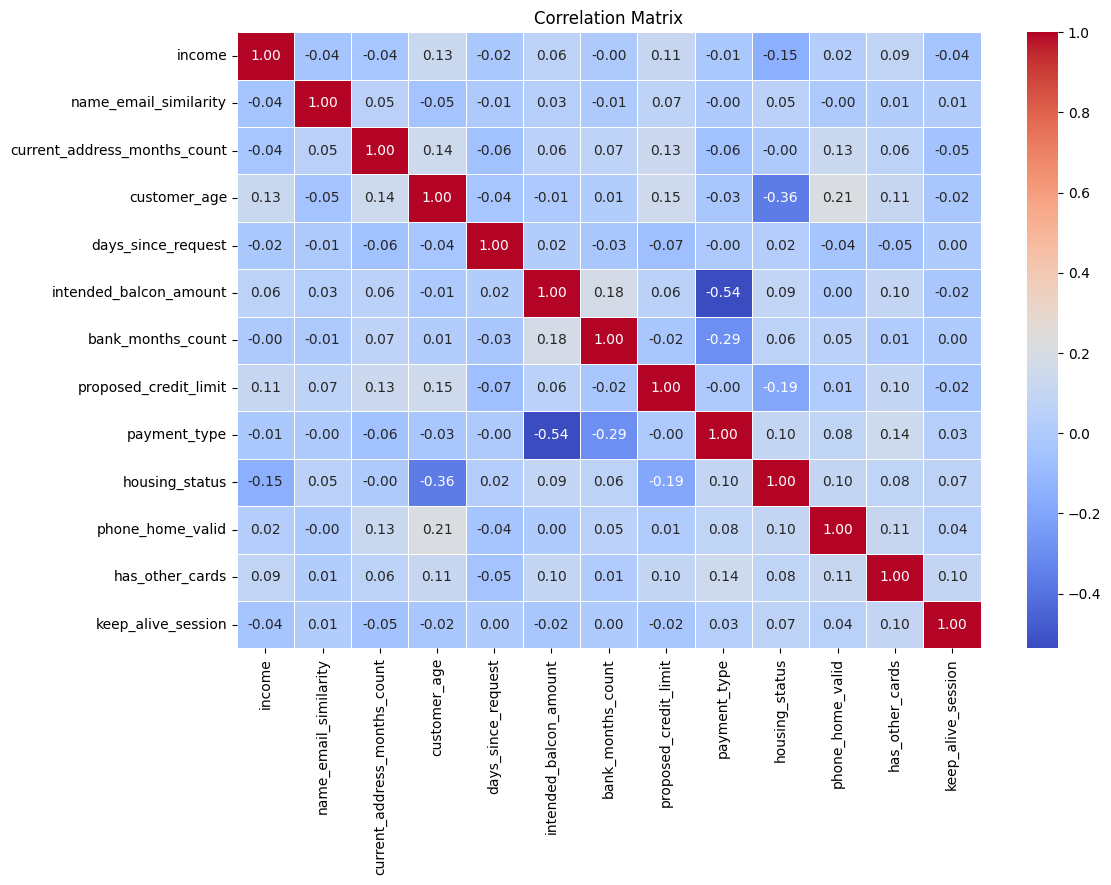

In [44]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()